<a href="https://colab.research.google.com/github/skardec/deeply_kardec/blob/main/poincar%C3%A8_hopf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

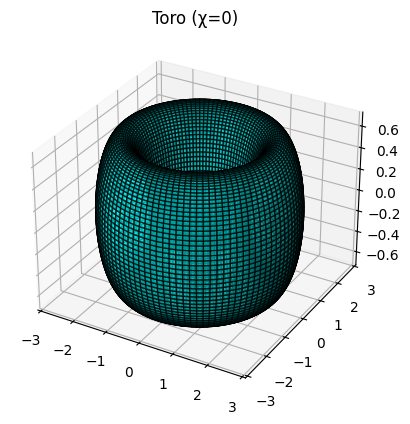

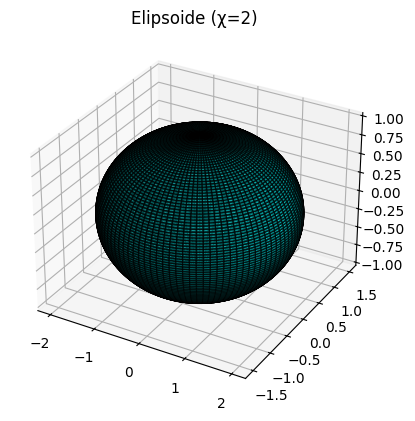

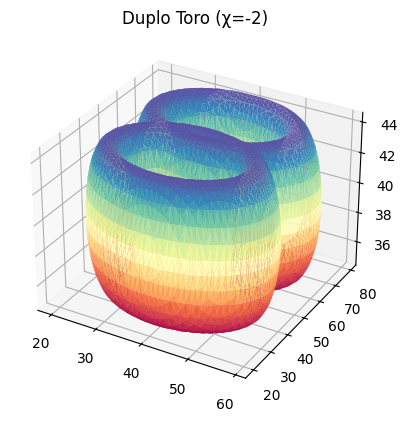

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Para superfícies implícitas
from skimage.measure import marching_cubes

# Função para plotar parametrizações
def plot_parametric(X, Y, Z, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, color='cyan', alpha=0.7, edgecolor='k')
    ax.set_title(title)
    plt.show()

# ----------------------
# 1. Toro (χ=0)
u = np.linspace(0, 2*np.pi, 100)
v = np.linspace(0, 2*np.pi, 100)
u, v = np.meshgrid(u, v)

R, r = 2, 0.7
X = (R + r*np.cos(v)) * np.cos(u)
Y = (R + r*np.cos(v)) * np.sin(u)
Z = r * np.sin(v)

plot_parametric(X, Y, Z, "Toro (χ=0)")

# ----------------------
# 2. Elipsoide (χ=2)
u = np.linspace(0, 2*np.pi, 100)
v = np.linspace(0, np.pi, 100)
u, v = np.meshgrid(u, v)

a, b, c = 2, 1.5, 1
X = a * np.cos(u) * np.sin(v)
Y = b * np.sin(u) * np.sin(v)
Z = c * np.cos(v)

plot_parametric(X, Y, Z, "Elipsoide (χ=2)")

# ----------------------
# 3. Superfície com χ < 0 (Duplo Toro aproximado)
# Definição implícita da superfície
def double_torus_eq(x, y, z, R=1.5, r=0.5):
    f1 = (x**2 + y**2 + z**2 + R**2 - r**2)**2 - 4*R**2*(x**2 + y**2)
    f2 = ((x-2.5)**2 + y**2 + z**2 + R**2 - r**2)**2 - 4*R**2*((x-2.5)**2 + y**2)
    return np.minimum(f1, f2)  # união de dois toros

# Grid 3D
grid = 80
x = np.linspace(-4, 4, grid)
y = np.linspace(-4, 4, grid)
z = np.linspace(-4, 4, grid)
X, Y, Z = np.meshgrid(x, y, z)
values = double_torus_eq(X, Y, Z)

# Extrai superfície usando Marching Cubes
verts, faces, _, _ = marching_cubes(values, level=0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                cmap='Spectral', lw=1)
ax.set_title("Duplo Toro (χ=-2)")
plt.show()


Gerando aproximação para gênero g=3 -> χ = -4


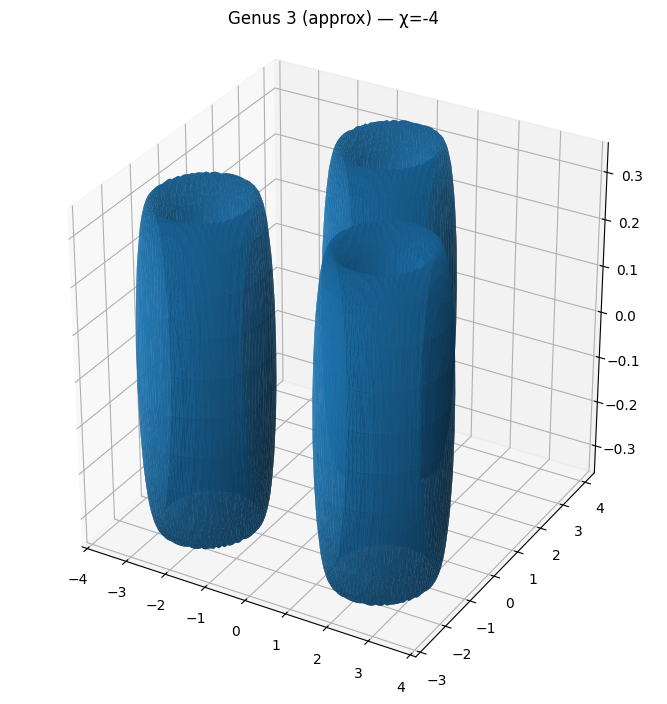

Gerando aproximação para gênero g=4 -> χ = -6


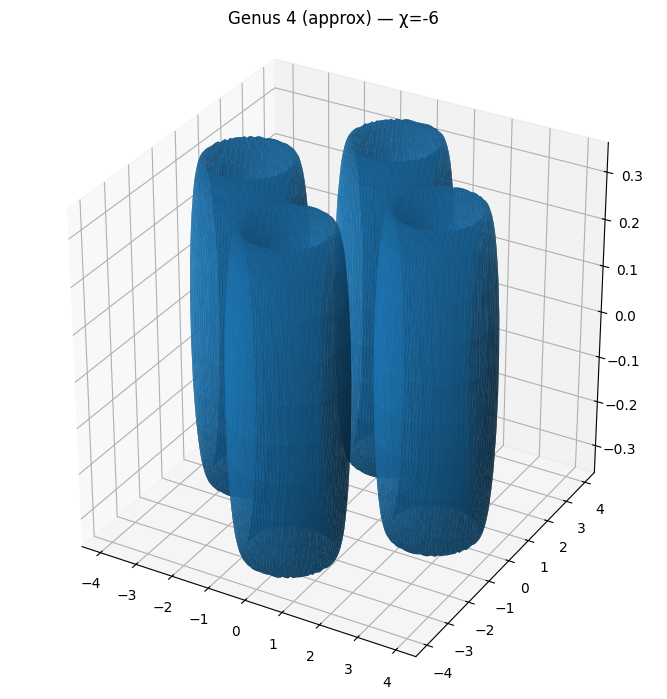

Gerando aproximação para gênero g=5 -> χ = -8


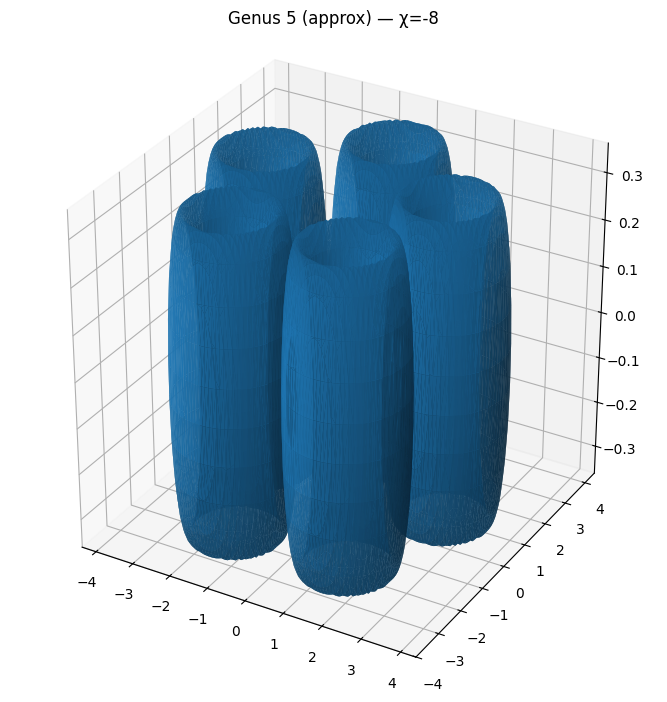

In [ ]:
"""
Genus-t surface approximations by overlapping torus implicit functions.
Requires: numpy, matplotlib, scikit-image
Instale: pip install numpy matplotlib scikit-image
"""

import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def torus_implicit(x, y, z, R=1.0, r=0.4, cx=0.0, cy=0.0, cz=0.0):
    """
    Implicit function for a (shifted) torus centered at (cx,cy,cz).
    Zero level approximates the torus surface.
    """
    X = x - cx
    Y = y - cy
    Z = z - cz
    s = X**2 + Y**2 + Z**2 + R**2 - r**2
    return s**2 - 4 * R**2 * (X**2 + Y**2)

def genus_surface_field(grid_x, grid_y, grid_z, genus=3, R=1.2, r=0.4, radius_circle=2.2):
    """
    Create scalar field whose zero level approximates a connected sum of `genus` torii.
    We place `genus` torii centers on a circle of radius `radius_circle` and take the minimum
    of their implicit functions so we get a single (possibly connected) shape.
    """
    # prepare grid
    X, Y, Z = np.meshgrid(grid_x, grid_y, grid_z, indexing='xy')
    # start with large positive field
    field = np.full_like(X, fill_value=np.inf, dtype=float)
    # place torii around a circle in the xy-plane (z offset 0)
    for k in range(genus):
        theta = 2 * np.pi * k / genus
        cx = radius_circle * np.cos(theta)
        cy = radius_circle * np.sin(theta)
        cz = 0.0
        f = torus_implicit(X, Y, Z, R=R, r=r, cx=cx, cy=cy, cz=cz)
        # use minimum to form union/overlap (common trick)
        field = np.minimum(field, f)
    return field

def extract_and_plot(field, grid_x, grid_y, grid_z, title="Genus surface (approx)"):
    # marching_cubes expects a 3D ndarray (z fastest?), but we'll pass field as is.
    # We want level=0 (zero-isosurface)
    verts, faces, normals, values = marching_cubes(field, level=0.0, spacing=(grid_x[1]-grid_x[0],
                                                                              grid_y[1]-grid_y[0],
                                                                              grid_z[1]-grid_z[0]))
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection='3d')
    # plot mesh
    ax.plot_trisurf(verts[:, 0] + grid_x[0],  # translate verts: marching_cubes returns vertex coords relative to grid start?
                    verts[:, 1] + grid_y[0],
                    faces, verts[:, 2] + grid_z[0],
                    linewidth=0.2, antialiased=True, alpha=0.9)
    ax.set_box_aspect([1,1,1])
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # --- parameters you can tweak ---
    genus_list = [3, 4, 5]        # gêneros que queremos (g=3 => chi=-4, etc)
    grid_n = 120                  # resolução do grid (aumente para mais detalhe; cuidado com memória)
    span = 5.0                    # tamanho do domínio [-span, span]^3
    R = 1.1                       # R (distância do centro do toro ao centro do tubo)
    r = 0.35                      # r (raio do tubo do toro)
    radius_circle = 2.5           # raio do círculo onde se posicionam os centros dos toros

    # grid
    x = np.linspace(-span, span, grid_n)
    y = np.linspace(-span, span, grid_n)
    z = np.linspace(-span, span, grid_n)

    for g in genus_list:
        # compute Euler characteristic for clarity
        chi = 2 - 2 * g
        print(f"Gerando aproximação para gênero g={g} -> χ = {chi}")

        field = genus_surface_field(x, y, z, genus=g, R=R, r=r, radius_circle=radius_circle)

        # optional: smooth/blur field to help connectivity (uncomment se quiser)
        # from scipy.ndimage import gaussian_filter
        # field = gaussian_filter(field, sigma=1.0)

        title = f"Genus {g} (approx) — χ={chi}"
        extract_and_plot(field, x, y, z, title=title)


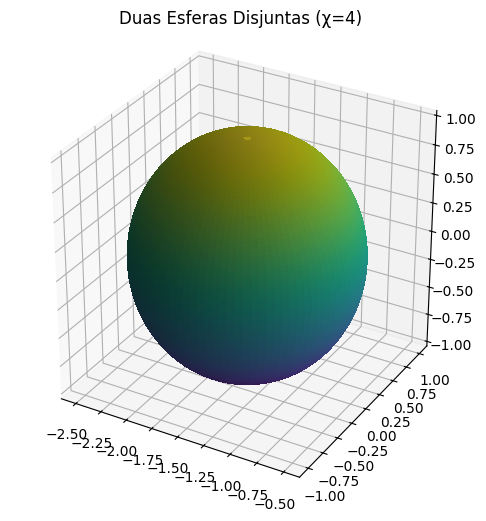

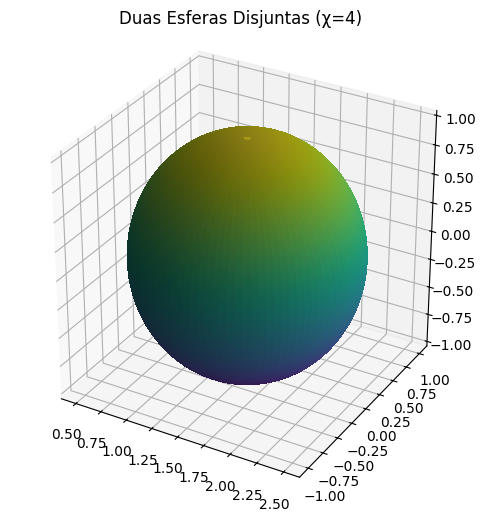

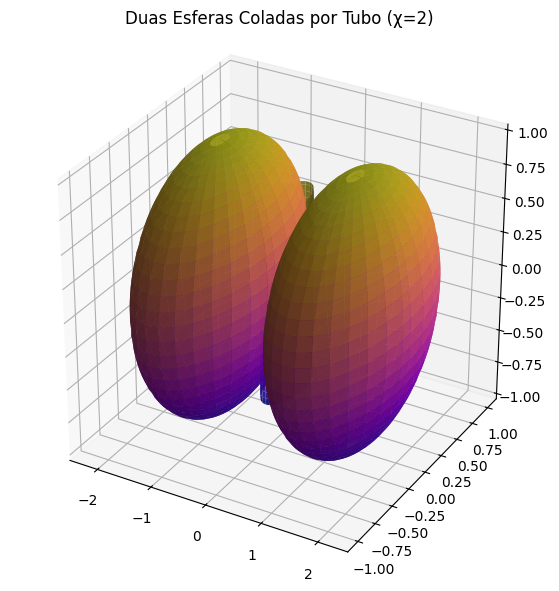

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_surface(X, Y, Z, C, title):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis(C),
                           rstride=1, cstride=1, linewidth=0, antialiased=False)
    ax.set_box_aspect([1,1,1])
    ax.set_title(title)
    plt.show()

# ----------------------
# 1. Duas esferas disjuntas (χ = 4)
u = np.linspace(0, 2*np.pi, 100)
v = np.linspace(0, np.pi, 100)
u, v = np.meshgrid(u, v)

r = 1.0
# primeira esfera no centro (-1.5,0,0)
X1 = r*np.cos(u)*np.sin(v) - 1.5
Y1 = r*np.sin(u)*np.sin(v)
Z1 = r*np.cos(v)
C1 = (Z1 - Z1.min()) / (Z1.max()-Z1.min())

# segunda esfera no centro (1.5,0,0)
X2 = r*np.cos(u)*np.sin(v) + 1.5
Y2 = r*np.sin(u)*np.sin(v)
Z2 = r*np.cos(v)
C2 = (Z2 - Z2.min()) / (Z2.max()-Z2.min())

plot_surface(X1, Y1, Z1, C1, "Duas Esferas Disjuntas (χ=4)")
plot_surface(X2, Y2, Z2, C2, "Duas Esferas Disjuntas (χ=4)")

# ----------------------
# 2. Duas esferas "coladas" por um tubo (χ = 2)
# vamos fazer transladas e depois conectar suavemente
R = 1.0
theta = np.linspace(0, 2*np.pi, 60)
phi = np.linspace(0, np.pi, 60)
theta, phi = np.meshgrid(theta, phi)

# Esfera esquerda
Xl = R*np.cos(theta)*np.sin(phi) - 1.2
Yl = R*np.sin(theta)*np.sin(phi)
Zl = R*np.cos(phi)

# Esfera direita
Xr = R*np.cos(theta)*np.sin(phi) + 1.2
Yr = R*np.sin(theta)*np.sin(phi)
Zr = R*np.cos(phi)

# Tubo conectando (cilindro)
z_cyl = np.linspace(-0.7, 0.7, 60)
ang = np.linspace(0, 2*np.pi, 60)
ang, z_cyl = np.meshgrid(ang, z_cyl)
Rt = 0.3
Xt = Rt*np.cos(ang)
Yt = Rt*np.sin(ang)
Zt = z_cyl

# Cores baseadas em Z
Cl = (Zl - Zl.min())/(Zl.max()-Zl.min())
Cr = (Zr - Zr.min())/(Zr.max()-Zr.min())
Ct = (Zt - Zt.min())/(Zt.max()-Zt.min())

# Plot
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xl, Yl, Zl, facecolors=plt.cm.plasma(Cl), linewidth=0, alpha=0.9)
ax.plot_surface(Xr, Yr, Zr, facecolors=plt.cm.plasma(Cr), linewidth=0, alpha=0.9)
ax.plot_surface(Xt, Yt, Zt, facecolors=plt.cm.plasma(Ct), linewidth=0, alpha=0.9)
ax.set_box_aspect([1,1,1])
ax.set_title("Duas Esferas Coladas por Tubo (χ=2)")
plt.show()


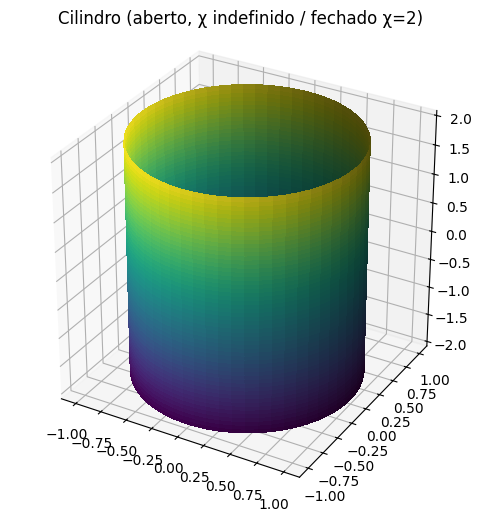

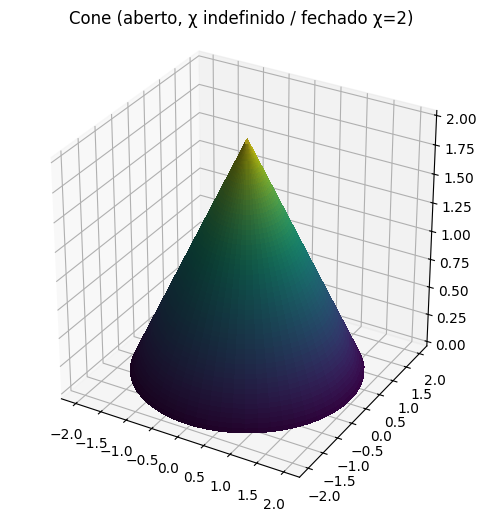

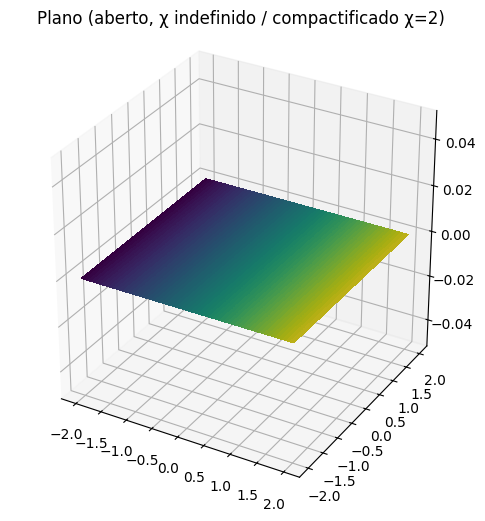

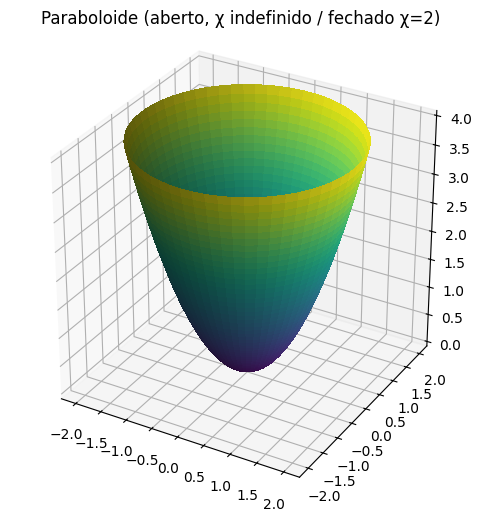

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_surface(X, Y, Z, C, title):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis(C),
                    rstride=1, cstride=1, linewidth=0, antialiased=False)
    ax.set_title(title)
    ax.set_box_aspect([1,1,1])
    plt.show()

# ----------------------
# 1. Cilindro (χ não definida aberto; se fechado, χ=2)
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(-2, 2, 60)
u, v = np.meshgrid(u, v)
R = 1
X = R*np.cos(u)
Y = R*np.sin(u)
Z = v
C = (Z - Z.min())/(Z.max()-Z.min())
plot_surface(X, Y, Z, C, "Cilindro (aberto, χ indefinido / fechado χ=2)")

# ----------------------
# 2. Cone (χ indefinido aberto / fechado χ=2)
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, 2, 60)
u, v = np.meshgrid(u, v)
X = v*np.cos(u)
Y = v*np.sin(u)
Z = 2 - v
C = (Z - Z.min())/(Z.max()-Z.min())
plot_surface(X, Y, Z, C, "Cone (aberto, χ indefinido / fechado χ=2)")

# ----------------------
# 3. Plano (χ indefinido; compactificado → χ=2)
u = np.linspace(-2, 2, 60)
v = np.linspace(-2, 2, 60)
u, v = np.meshgrid(u, v)
X = u
Y = v
Z = np.zeros_like(u)
C = (X - X.min())/(X.max()-X.min())
plot_surface(X, Y, Z, C, "Plano (aberto, χ indefinido / compactificado χ=2)")

# ----------------------
# 4. Paraboloide (χ indefinido; compactificado χ=2)
r = np.linspace(0, 2, 60)
theta = np.linspace(0, 2*np.pi, 60)
r, theta = np.meshgrid(r, theta)
X = r*np.cos(theta)
Y = r*np.sin(theta)
Z = r**2
C = (Z - Z.min())/(Z.max()-Z.min())
plot_surface(X, Y, Z, C, "Paraboloide (aberto, χ indefinido / fechado χ=2)")


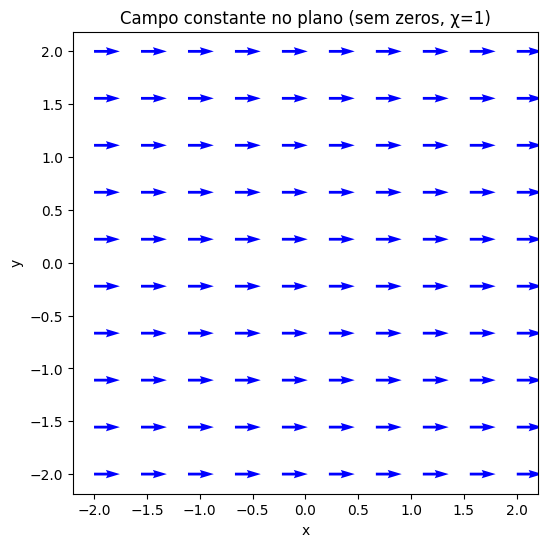

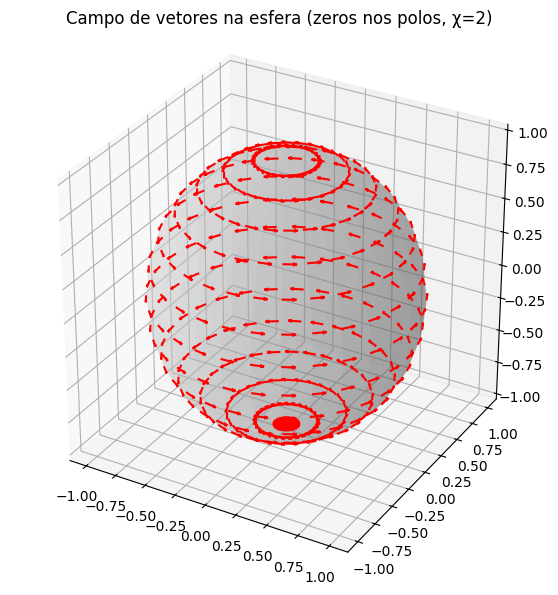

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------
# 1. Campo no plano
x = np.linspace(-2, 2, 10)
y = np.linspace(-2, 2, 10)
X, Y = np.meshgrid(x, y)

U = np.ones_like(X)   # componente x = 1
V = np.zeros_like(Y)  # componente y = 0

plt.figure(figsize=(6,6))
plt.quiver(X, Y, U, V, color="blue")
plt.title("Campo constante no plano (sem zeros, χ=1)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()


# -------------------
# 2. Campo na esfera
# Parametrização da esfera
phi = np.linspace(0, np.pi, 15)       # latitude
theta = np.linspace(0, 2*np.pi, 30)   # longitude
phi, theta = np.meshgrid(phi, theta)

X = np.sin(phi)*np.cos(theta)
Y = np.sin(phi)*np.sin(theta)
Z = np.cos(phi)

# Campo de rotação em torno do eixo z: V=(-y,x,0)
U = -Y
V = X
W = np.zeros_like(Z)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W, length=0.1, normalize=True, color="red")

# esfera de fundo
ax.plot_surface(X, Y, Z, color="lightgray", alpha=0.3)

ax.set_title("Campo de vetores na esfera (zeros nos polos, χ=2)")
ax.set_box_aspect([1,1,1])
plt.show()


In [92]:
# ============================
# 1. Montar o Google Drive
# ============================
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import os
from pathlib import Path

# --------------------------
# 2. Configurações
# --------------------------
rng = np.random.default_rng()  # cada execução vai gerar pontos diferentes
N_surfaces = 1      # número de superfícies diferentes por classe
per_surface = 500000   # pontos por superfície
classes = {0: "torus", 1: "ellipsoid" } #, 2: "paraboloid", 3: "plane", 4: "cone"}

# pasta onde salvar no seu Drive
out_dir = Path("/content/drive/MyDrive/dataset_surfaces")
out_dir.mkdir(parents=True, exist_ok=True)

# --------------------------
# 3. Funções de amostragem
# --------------------------
def sample_torus(center, R, r, n):
    u = rng.uniform(0, 2*np.pi, n)
    v = rng.uniform(0, 2*np.pi, n)
    x = (R + r*np.cos(v)) * np.cos(u) + center[0]
    y = (R + r*np.cos(v)) * np.sin(u) + center[1]
    z = r * np.sin(v) + center[2]
    return np.column_stack([x,y,z])

def sample_ellipsoid(center, a,b,c, n):
    u = rng.uniform(0, 2*np.pi, n)
    v = rng.uniform(0, np.pi, n)
    x = a * np.cos(u) * np.sin(v) + center[0]
    y = b * np.sin(u) * np.sin(v) + center[1]
    z = c * np.cos(v) + center[2]
    return np.column_stack([x,y,z])

# def sample_paraboloid(center, A, n, rmax=1.8):
#     rho = rng.uniform(0, rmax, n)
#     theta = rng.uniform(0, 2*np.pi, n)
#     x = rho * np.cos(theta) + center[0]
#     y = rho * np.sin(theta) + center[1]
#     z = A * ( (x-center[0])**2 + (y-center[1])**2 ) + center[2]
#     return np.column_stack([x,y,z])

# def sample_plane(center, normal, size, n):
#     normal = np.array(normal) / np.linalg.norm(normal)
#     if abs(normal[0]) < 0.9:
#         v = np.array([1.,0.,0.])
#     else:
#         v = np.array([0.,1.,0.])
#     e1 = np.cross(normal, v); e1 /= np.linalg.norm(e1)
#     e2 = np.cross(normal, e1); e2 /= np.linalg.norm(e2)
#     a = rng.uniform(-size, size, n)
#     b = rng.uniform(-size, size, n)
#     pts = center + np.outer(a, e1) + np.outer(b, e2)
#     return pts

# def sample_cone(apex, axis_dir, height, radius_base, n):
#     axis = np.array(axis_dir) / np.linalg.norm(axis_dir)
#     if abs(axis[0]) < 0.9:
#         v = np.array([1.,0.,0.])
#     else:
#         v = np.array([0.,1.,0.])
#     e1 = np.cross(axis, v); e1 /= np.linalg.norm(e1)
#     e2 = np.cross(axis, e1); e2 /= np.linalg.norm(e2)
#     t = rng.uniform(0, height, n)
#     theta = rng.uniform(0, 2*np.pi, n)
#     r_at_t = (t / height) * radius_base
#     pts = apex + np.outer(t, axis) + (np.outer(r_at_t*np.cos(theta), e1) + np.outer(r_at_t*np.sin(theta), e2))
#     return pts

# --------------------------
# 4. Gerar dataset
# --------------------------
all_classes = []
for cls in classes:
    name = classes[cls]
    samples_cls = []
    for s in range(N_surfaces):
        center = rng.uniform(-2.9, 2.9, size=3)
        if cls == 0:  # torus
            R = rng.uniform(0.8, 2.0); r = rng.uniform(0.1, 0.6)
            pts = sample_torus(center, R, r, per_surface)
        elif cls == 1:  # ellipsoid
            a = rng.uniform(0.6, 2.0); b = rng.uniform(0.6, 2.0); c = rng.uniform(0.4, 2.0)
            pts = sample_ellipsoid(center, a, b, c, per_surface)
        # elif cls == 2:  # paraboloid
        #     A = rng.uniform(0.3, 1.5)
        #     pts = sample_paraboloid(center, A, per_surface)
        # elif cls == 3:  # plane
        #     normal = rng.normal(size=3); normal /= np.linalg.norm(normal)
        #     size = rng.uniform(0.8, 2.5)
        #     pts = sample_plane(center, normal, size, per_surface)
        # elif cls == 4:  # cone
        #     apex = center + rng.uniform(-0.5,0.5,size=3)
        #     axis = rng.normal(size=3)
        #     height = rng.uniform(0.8, 2.2)
        #     radius_base = rng.uniform(0.3, 1.2)
        #     pts = sample_cone(apex, axis, height, radius_base, per_surface)
        lbl = np.full((pts.shape[0],1), cls)
        samples_cls.append(np.hstack([pts,lbl]))
    samples_cls = np.vstack(samples_cls)
    all_classes.append(samples_cls)

# juntar todas classes
combined = np.vstack(all_classes)

# embaralhar
rng.shuffle(combined)

# --------------------------
# 5. Salvar no Drive
# --------------------------
file_path = out_dir / "dados.txt"
np.savetxt(file_path, combined, delimiter=",", header="x,y,z,class", comments="")

print("Dataset salvo em:", file_path)
print("Shape final:", combined.shape)
print("Primeiras linhas:\n", combined[:5])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset salvo em: /content/drive/MyDrive/dataset_surfaces/dados.txt
Shape final: (1000000, 4)
Primeiras linhas:
 [[-3.25887333  0.5607664   0.17626782  0.        ]
 [-2.55616515 -0.48436682  2.52334088  1.        ]
 [-2.57598495 -2.09839344  2.84638142  1.        ]
 [-2.44038899 -3.64063317  1.47308261  1.        ]
 [-4.14590141 -0.82250884  0.34303677  0.        ]]


In [93]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from google.colab import drive

In [94]:
# =====================
# 1. Montar Drive
# =====================
drive.mount('/content/drive')

# caminho do banco de dados no Drive
file_path = "/content/drive/MyDrive/dataset_surfaces/dados.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:

# =====================
# 2. Carregar dados
# =====================
data = np.loadtxt(file_path, delimiter=",", skiprows=1)  # x,y,z,class
X = data[:, :3]
y = data[:, 3].astype(int)

# Normalização
max_val = np.abs(X).max()
X = X.astype("float32") #/ max_val

In [96]:

# =====================
# 3. Agrupar em blocos de 100 pontos
# =====================
n_points = 100
n_samples = len(X) // n_points
X = X[:n_samples * n_points].reshape(n_samples, n_points, 3, 1)
y = y[:n_samples * n_points].reshape(n_samples, n_points)
# Como cada bloco é de uma única classe, pegamos a primeira label
y = y[:, 0]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10000, 100, 3, 1)
y shape: (10000,)


In [97]:
# =====================
# 4. Dividir em treino/teste
# =====================
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# One-hot encoding das classes
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [70]:
# =====================
# 5. Modelo
# =====================
input_shape = (100, 3, 1)

model = keras.Sequential([
    keras.Input(shape=input_shape),
    #layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    #layers.MaxPooling2D(pool_size=(2, 2)),
    #layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    #layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    #layers.Flatten(),
    layers.Dropout(0.3),
    #layers.Dropout(0.3),
    layers.Dense(num_classes, activation="linear"),
    #layers.Dense(num_classes, activation="relu"),
    #layers.Dense(num_classes),
    #layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dense(num_classes, activation="softmax"),
])

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 2)              │           602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608 (2.38 KB)

 Trainable params: 608 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# =====================
# 3. Modelo puramente denso
# =====================
#input_shape = (n_points * 3,)
input_shape = (100, 3, 1)

model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Flatten(),
    layers.Dense(num_classes, activation="tanh"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="tanh"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="tanh"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="tanh"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="softmax"),
])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_16 (Flatten)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 2)              │           602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626 (2.45 KB)

 Trainable params: 626 (2.45 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# =====================
# 6. Compilar e treinar
# =====================
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=100,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5030 - loss: 0.7884 - val_accuracy: 0.5150 - val_loss: 0.7027
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5168 - loss: 0.7323 - val_accuracy: 0.5300 - val_loss: 0.6936
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5175 - loss: 0.7170 - val_accuracy: 0.5713 - val_loss: 0.6860
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5156 - loss: 0.7003 - val_accuracy: 0.5813 - val_loss: 0.6800
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5373 - loss: 0.6886 - val_accuracy: 0.6112 - val_loss: 0.6755
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5216 - loss: 0.6868 - val_accuracy: 0.6338 - val_loss: 0.6665
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5835 - loss: 0.6716 - val_accuracy: 0.6450 - val_loss: 0.6572
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5690 - loss: 0.6638 - val_accuracy: 0.6963 - 

In [100]:
# =====================
# 7. Avaliar
# =====================
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("Test accuracy:", test_acc)

63/63 - 0s - 2ms/step - accuracy: 0.9995 - loss: 0.0019
Test accuracy: 0.9994999766349792


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# --------------------
# Carregar dados
data = np.loadtxt("dados.txt", delimiter=",", skiprows=1)  # x,y,z,class
X = data[:, :3]
y = data[:, 3].astype(int)

# Normalização
max_val = np.abs(X).max()
X = X.astype("float32") / max_val

# --------------------
# Agrupar em blocos de 100 pontos
n_points = 100
n_samples = len(X) // n_points
X = X[:n_samples * n_points].reshape(n_samples, n_points, 3, 1)
y = y[:n_samples * n_points].reshape(n_samples, n_points)
# Como cada bloco é de uma única classe, pegamos a primeira label
y = y[:,0]

print("X shape:", X.shape)
print("y shape:", y.shape)

# --------------------
# Dividir em treino/teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# One-hot encoding das classes
num_classes = 5
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# --------------------
# Modelo
input_shape = (100, 3, 1)

model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

model.summary()

# --------------------
# Compilar e treinar
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=32, epochs=15, validation_split=0.1)

# Avaliar
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("Test accuracy:", test_acc)
